Putting the sequential feeding of data into the RNN part of the RNN module (how else are we going to be able to train our thalamus layer??). Implements strucutre of RNN then linear layer then RNN. DOES NOT RUN BUT I AM TIRED AND AM GIVING UP

In [2]:
from scipy.io import loadmat
import numpy as np
import torch 


In [3]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]


In [4]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

341.0


In [5]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [6]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

(502, 341, 21)


In [7]:
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       # train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_input[train_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
       train_output[train_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
        test_output[test_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
        test_ind += 1





- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> no
- Hessian free optimization --> yes
- birdirectional --> no

In [8]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)

    print(output.shape)
    print(target.shape)
    loss = torch.sum((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [26]:
from torch import nn

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False


model = MilliesRNN(in_dim, hid_dim, out_dim)
criterion = nn.MSELoss() 
# criterion = hardcore_loss
if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

model.train()
for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5): # minibatching w/ replacement   
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(idx)
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))    

        loss = criterion(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        # loss = criterion(outputs, torch.from_numpy(train_output).to(torch.float32), model.named_parameters())
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )
        



Epoch [1/10], Step [1/401], Loss: 0.0262
Epoch [1/10], Step [2/401], Loss: 0.0251
Epoch [1/10], Step [3/401], Loss: 0.0236
Epoch [1/10], Step [4/401], Loss: 0.0213
Epoch [1/10], Step [5/401], Loss: 0.0208
Epoch [2/10], Step [1/401], Loss: 0.0212
Epoch [2/10], Step [2/401], Loss: 0.0204
Epoch [2/10], Step [3/401], Loss: 0.0192
Epoch [2/10], Step [4/401], Loss: 0.0188
Epoch [2/10], Step [5/401], Loss: 0.0193
Epoch [3/10], Step [1/401], Loss: 0.0191
Epoch [3/10], Step [2/401], Loss: 0.0183
Epoch [3/10], Step [3/401], Loss: 0.0180
Epoch [3/10], Step [4/401], Loss: 0.0181
Epoch [3/10], Step [5/401], Loss: 0.0180
Epoch [4/10], Step [1/401], Loss: 0.0175
Epoch [4/10], Step [2/401], Loss: 0.0171
Epoch [4/10], Step [3/401], Loss: 0.0171
Epoch [4/10], Step [4/401], Loss: 0.0173
Epoch [4/10], Step [5/401], Loss: 0.0164
Epoch [5/10], Step [1/401], Loss: 0.0162
Epoch [5/10], Step [2/401], Loss: 0.0163
Epoch [5/10], Step [3/401], Loss: 0.0158
Epoch [5/10], Step [4/401], Loss: 0.0161
Epoch [5/10], St

Text(0, 0.5, 'mse loss')

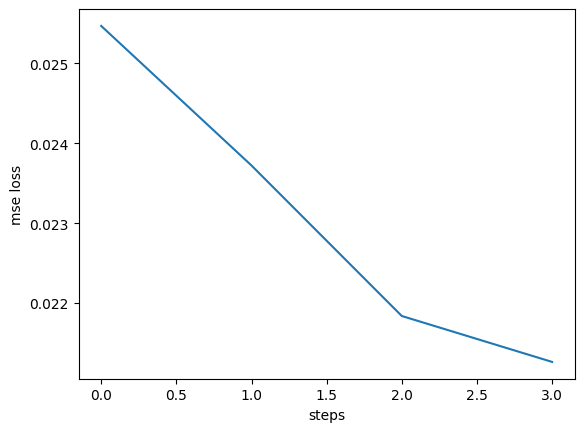

In [13]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("mse loss")

In [14]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

ValueError: cannot reshape array of size 4 into shape (3)

In [15]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    for (input, output) in test_dataset:
        out, hidden_state = model(input)
        loss = criterion(out, output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

NameError: name 'test_dataset' is not defined

In [16]:
    """for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )"""

'for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples\n\n    gen_output, hn = model(input)        \n\n    loss = criterion(gen_output, output)\n    nn.utils.clip_grad_norm_(model.parameters(), 1)\n    def closure():\n        gen_output, _ = model(input)\n        loss = criterion(gen_output, output)\n        loss.backward(create_graph=True)\n        return loss, gen_output\n    optimizer.step(closure, M_inv=None)\n    # add regularization loss with rate and weights here??\n    # rate by taking L2 with matrix of zeroes\n    loss_error.append(loss.item())\n    \n    if i == 0 or (i + 1) % print_interval == 0:\n        print(\n            f"Epoch [{epoch + 1}/{num_epochs}], "\n            f"Step [{i + 1}/{len(train_dataset)}], "\n            f"Loss: {loss.item():.4f}"\n        )'

In [31]:
from torch import nn

from mrnn import MilliesRNN
from hessianfree import HessianFree

import torch.nn.utils.prune as prune
import torch.nn.functional as F

learning_rate = 0.001
hessian = False

model2 = MilliesRNN(in_dim, hid_dim, out_dim)

module1 = model2.h2o
prune.random_unstructured(module1, name="weight", amount=0.9)
module2 = model2.thal
prune.random_unstructured(module2, name="weight", amount=0.9)


criterion = nn.MSELoss() 
# criterion = hardcore_loss
if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

model.train()
for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5): # minibatching w/ replacement   
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(idx)
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))    

        loss = criterion(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        # loss = criterion(outputs, torch.from_numpy(train_output).to(torch.float32), model.named_parameters())
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )

Epoch [1/10], Step [1/401], Loss: 0.0116
Epoch [1/10], Step [2/401], Loss: 0.0120
Epoch [1/10], Step [3/401], Loss: 0.0115
Epoch [1/10], Step [4/401], Loss: 0.0111
Epoch [1/10], Step [5/401], Loss: 0.0108
Epoch [2/10], Step [1/401], Loss: 0.0107
Epoch [2/10], Step [2/401], Loss: 0.0113
Epoch [2/10], Step [3/401], Loss: 0.0115
Epoch [2/10], Step [4/401], Loss: 0.0112
Epoch [2/10], Step [5/401], Loss: 0.0119
Epoch [3/10], Step [1/401], Loss: 0.0114
Epoch [3/10], Step [2/401], Loss: 0.0110
Epoch [3/10], Step [3/401], Loss: 0.0111
Epoch [3/10], Step [4/401], Loss: 0.0117
Epoch [3/10], Step [5/401], Loss: 0.0111
Epoch [4/10], Step [1/401], Loss: 0.0109
Epoch [4/10], Step [2/401], Loss: 0.0111
Epoch [4/10], Step [3/401], Loss: 0.0110
Epoch [4/10], Step [4/401], Loss: 0.0115
Epoch [4/10], Step [5/401], Loss: 0.0117
Epoch [5/10], Step [1/401], Loss: 0.0111
Epoch [5/10], Step [2/401], Loss: 0.0113
Epoch [5/10], Step [3/401], Loss: 0.0113
Epoch [5/10], Step [4/401], Loss: 0.0111
Epoch [5/10], St

Text(0, 0.5, 'mse loss')

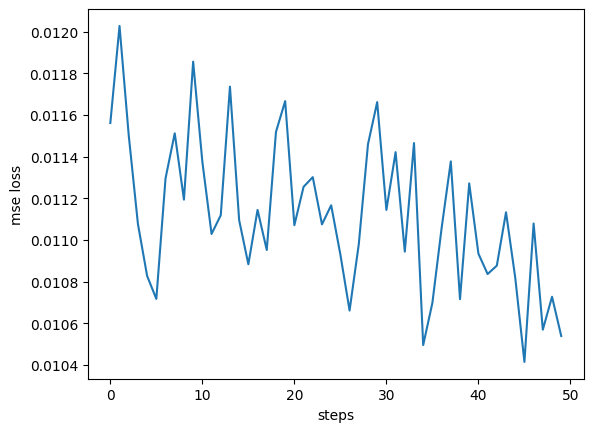

In [32]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("mse loss")
